## 19.2 新闻抓取

### 19.2.1 调试

In [1]:
import requests
from bs4 import BeautifulSoup
import jieba.posseg as pseg
import re
import jieba
from wordcloud import WordCloud
from textrank4zh import TextRank4Keyword, TextRank4Sentence
import matplotlib.pyplot as plt

#### 1 request请求

In [2]:
url = "https://3w.huanqiu.com/a/c36dc8/3xqGPRBcUE6?agt=8"
# url = "https://mbd.baidu.com/newspage/data/landingsuper?context=%7B%22nid%22%3A%22news_10016614571851138282%22%7D&n_type=0&p_from=1"

In [3]:
html = requests.get(url, timeout=10)
content = html.content
content[:100]

b'<!DOCTYPE html>\n<html lang="zh">\n<head>\n    <meta charset="UTF-8">\n    <title>\xe7\x89\xb9\xe6\x9c\x97\xe6\x99\xae\xe5\xae\xa3\xe5\xb8\x83\xe2\x80\x9c\xe6\x96\xad\xe4'

#### 2 使用BeautfulSoup对象解析

In [4]:
soup = BeautifulSoup(content, "html.parser", from_encoding="utf-8")
# soup

In [5]:
text = soup.get_text()
text

'\n\n\n\n特朗普宣布“断供”世卫，联合国秘书长：现在不是减少抗疫行动所需资源的时候\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n特朗普宣布“断供”世卫，联合国秘书长：现在不是减少抗疫行动所需资源的时候\n\n2020-04-15 09:09\n\n朱梦颖\n\n环球网\n\n\n\n【环球网快讯】美国总统特朗普14日宣布暂停资助世卫组织。对此，据路透社最新消息，联合国秘书长古特雷斯在一份声明中回应表示，“现在不是减少世界卫生组织或任何其他人道主义组织用于抗击病毒行动所需资源的时候。”“现在是团结的时候，是国际社会齐心协力一起制止病毒（传播）及其破坏性后果的时候。”声明还写道。此前报道：特朗普宣布美国将暂停资助世卫组织，同日美国确诊病例超过60万【环球网报道 记者 刘洋】CNN消息，美国总统特朗普14日在白宫记者会上宣布，美国将暂停资助世界卫生组织，并对后者进行审查。特朗普称，审查范围将包括世卫组织“在处置失当和隐瞒病毒扩散真相”上的作用。他指责世卫组织在病毒暴发初期反对美国政府对中国实施旅行限制的决定，“其他国家听了世卫组织的话对中国敞开大门，结果加速了病毒的传播”。不仅如此，他还指责世界卫生组织没有及时分享疫情信息，没有及时提供防疫政策建议，没有及时宣布“全球大流行”等。特朗普称“在这么长时间后，是时候让他们为此负责了”。就在特朗普宣布将暂停资助世界卫生组织这天，据美国约翰斯·霍普金斯大学发布的全球新冠肺炎数据实时统计系统，截至美国东部时间4月14日晚6时，全美共报告新冠肺炎确诊602989例，死亡25575例，共检测3081620例。在过去24小时，全美新增确诊25682例，新增死亡2356例。面对疫情，特朗普甩锅世卫组织的态度早已十分明显，并曾接连将矛头对准世卫组织。当地时间4月7日，特朗普在白宫每日疫情简报会上宣称，将“强有力地阻止”美国向WHO提供资金，因为该组织持有“以中国为中心”的立场。之后，4月8日，特朗普则继续攻击世卫组织，并称会在会费问题上“下决心”。\n\n责编：薛艺磊\n版权作品，未经环球网 huanqiu.com 书面授权，严禁转载，违者将被追究法律责任。\n\n\n阅读数(49921）\n不感兴趣不感兴趣广告软文重复、旧闻文章质量差文字、图片、视频等展示问题标题

#### 3 对文本分词，得到任务集合和地点集合

In [6]:
words = pseg.lcut(text)
words[:10]

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\LGB\AppData\Local\Temp\jieba.cache
Loading model cost 0.887 seconds.
Prefix dict has been built succesfully.


[pair('\n', 'x'),
 pair('\n', 'x'),
 pair('\n', 'x'),
 pair('\n', 'x'),
 pair('特朗普', 'nr'),
 pair('宣布', 'v'),
 pair('“', 'x'),
 pair('断供', 'v'),
 pair('”', 'x'),
 pair('世卫', 'n')]

In [7]:
# 人物集合
news_person = {word for word, flag in words if flag=="nr"}
news_person

{'刘洋', '朱梦颖', '特朗普', '特雷斯', '白宫', '薛艺磊'}

In [8]:
# 地点集合
news_place = {word for word, flag in words if flag=="ns"}
news_place

{'中国', '美国'}

#### 4 提取中文以及相关标点

In [9]:
text = re.sub(r'[^[\u4e00-\u9fa5。，！：、]{3，}', "", text)
text[:100]

'\n\n\n\n特朗普宣布“断供”世卫，联合国秘书长：现在不是减少抗疫行动所需资源的时候\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n特朗普宣布“断供”世卫，联合国秘书长：现在不是减少抗疫行动所需'

#### 5 去掉停用词

In [10]:
with open("../data/stopwords.txt", "r", encoding="utf-8") as fr:
    stop_words = fr.read()
    stop_words = stop_words.split("\n")
stop_words[:5]

[':', '：', '———', '》），', '）÷（１－']

In [11]:
def remove_stop_words(f, stop_words):
    for stop_word in stop_words:
        f = f.replace(stop_word, "")
    return f

#### 6 生成词云

In [12]:
def create_word_cloud(f, stop_words):
    f = remove_stop_words(f, stop_words)
    seg_list = jieba.lcut(f)
    cut_text = " ".join(seg_list)
    wc = WordCloud(
        max_words=100,
        width=2000,
        height=1200,
        font_path = "../data/msyh.ttf"
        
    )
    wordcloud = wc.generate(cut_text)
    wordcloud.to_file("wordcloud.jpg")
    return wordcloud


In [13]:
wordcloud = create_word_cloud(text, stop_words)
wordcloud

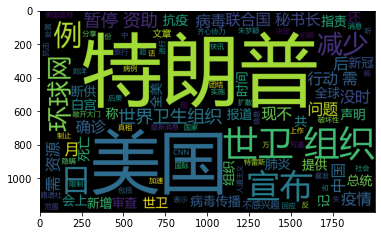

In [14]:
plt.imshow(wordcloud)

#### 7 通过TextRank4Keyword生成关键词和关键句

In [15]:
# 输出关键词，设置文本小写，窗口为2
tr4w = TextRank4Keyword()
tr4w.analyze(text=text, lower=True, window=3)
print('关键词：')
for item in tr4w.get_keywords(20, word_min_len=2):
    print(item.word, item.weight)

关键词：
组织 0.028046531859407576
世卫 0.0254631331840568
美国 0.024756675797885548
病毒 0.0188690707947476
特朗普 0.018438940780829072
问题 0.014106618454916724
确诊 0.012511450230337829
中国 0.012048983139129192
疫情 0.011031469273206794
没有 0.010617779522072518
宣布 0.010459303890547418
减少 0.010292811648871011
世界卫生组织 0.010161031563986853
现在 0.009153313775357974
环球网 0.008889870347676038
全球 0.008665392847715975
全美 0.008648506318631524
新冠 0.00850959986774303
新增 0.00842270362611322
提供 0.008281608662083925


In [16]:
# 输出重要的句子
tr4s = TextRank4Sentence()
tr4s.analyze(text=text, lower=True, source = 'all_filters')
print('摘要：')
# 重要性较高的三个句子
for item in tr4s.get_key_sentences(num=3):
    # index是语句在文本中位置，weight表示权重
    print(item.index, item.weight, item.sentence)

摘要：
9 0.07658082515605456 此前报道：特朗普宣布美国将暂停资助世卫组织，同日美国确诊病例超过60万【环球网报道 记者 刘洋】CNN消息，美国总统特朗普14日在白宫记者会上宣布，美国将暂停资助世界卫生组织，并对后者进行审查
5 0.06992346632713363 【环球网快讯】美国总统特朗普14日宣布暂停资助世卫组织
0 0.06731528412782758 特朗普宣布“断供”世卫，联合国秘书长：现在不是减少抗疫行动所需资源的时候


### 19.2.2 封装

In [17]:
# 1 得到html文件
def get_content(url):
    html = requests.get(url, timeout=10)
    content = html.content
    return content

# 2 得到解析后的文本
def get_text(content):
    soup = BeautifulSoup(content, "html.parser", from_encoding="utf-8")
    text = soup.get_text()
    return text

# 3 清洗文本，得到中文内容
def get_clean_text(text):
    text = re.sub(r'[^[\u4e00-\u9fa5。，！：、]{3，}', "", text)
    return text

# 4 得到停用词 
def get_stopwords(filename="../data/stopwords.txt"):
    with open(filename, "r", encoding="utf-8") as fr:
        stop_words = fr.read()
        stop_words = stop_words.split("\n")
        return stop_words

# 5 得到文章关键词
def get_keywords(text, stop_words, num_keywords=10):
    tr4w = TextRank4Keyword()
    tr4w.analyze(text=text, lower=True, window=3)
    print("*"*20,'关键词：',"*"*20)
    for item in tr4w.get_keywords(num_keywords, word_min_len=2):
        print(item.word, item.weight)
        
# 5 得到文章关键句：
def get_key_sentenses(text):
# 输出重要的句子
    tr4s = TextRank4Sentence()
    tr4s.analyze(text=text, lower=True, source = 'all_filters')
    print("*"*20,'摘要：',"*"*20)
    # 重要性较高的三个句子
    key_sentenses = []
    for item in tr4s.get_key_sentences(num=3):
        # index是语句在文本中位置，weight表示权重
        key_sentenses.append((item.index, item.weight, item.sentence))
    key_sentenses.sort(key=lambda x:x[0])
    for index, weight, sentence in key_sentenses:
        print(sentence)

# 7 移除文章中的停用词
def remove_stop_words(f, stop_words):
    for stop_word in stop_words:
        f = f.replace(stop_word, "")
    return f

# 8 生成词云
def create_word_cloud(f, stop_words, url, my_keywords = ["开课吧", "陈旸"]):
    f = remove_stop_words(f, stop_words)
    seg_list = jieba.lcut(f)
    cut_text = " ".join(seg_list)
    wc = WordCloud(
        max_words=100,
        width=2000,
        height=1200,
        font_path = "../data/msyh.ttf"
        
    )
    wordcloud = wc.generate(cut_text)
    wordcloud.to_file("wordcloud.jpg")
    print("*"*20, "词云", "*"*20)
    return wordcloud

    
# 9 main函数
def main(url, my_keywords=None):
    content = get_content(url)
    text = get_text(content)
    text = get_clean_text(text)
    stop_words = get_stopwords()
    get_keywords(text, stop_words)
    get_key_sentenses(text)
    wordcloud = create_word_cloud(text, stop_words, url)
    plt.imshow(wordcloud)

******************** 关键词： ********************
组织 0.028046531859407576
世卫 0.0254631331840568
美国 0.024756675797885548
病毒 0.0188690707947476
特朗普 0.018438940780829072
问题 0.014106618454916724
确诊 0.012511450230337829
中国 0.012048983139129192
疫情 0.011031469273206794
没有 0.010617779522072518
******************** 摘要： ********************
特朗普宣布“断供”世卫，联合国秘书长：现在不是减少抗疫行动所需资源的时候
【环球网快讯】美国总统特朗普14日宣布暂停资助世卫组织
此前报道：特朗普宣布美国将暂停资助世卫组织，同日美国确诊病例超过60万【环球网报道 记者 刘洋】CNN消息，美国总统特朗普14日在白宫记者会上宣布，美国将暂停资助世界卫生组织，并对后者进行审查
******************** 词云 ********************


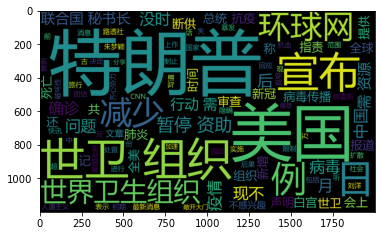

In [18]:
main("https://3w.huanqiu.com/a/c36dc8/3xqGPRBcUE6?agt=8")

******************** 关键词： ********************
清华 0.038889253972234444
献血 0.02410788158830776
无偿献血 0.019852942359804816
清华大学 0.015605529020906648
同学 0.010604329454089434
活动 0.009902002196232041
参与 0.008218831811224882
师生 0.007543245328999593
现场 0.00739743106766316
学生 0.007317552307211275
******************** 摘要： ********************
清华举办年度第四场大型无偿献血活动十五年来师生无偿献血突破两万人次清华新闻网12月13日电（通讯员 李文雅 魏经纬）“同学，恭喜你成为了清华无偿献血第20000人
时任校团委志愿中心辅导员罗锦文在《不在其中不流泪——清华献血现场纪实》一文中写道，“在现场，我还看见一个与志愿中心、红会、公益协会都不认识的同学协助服务，唯一的标识就是他穿着水立方寒假测试赛的制服，他默默地工作，悄无声息地离开，没有人知道他姓甚名谁，但我想这无妨，志愿者就是我们共同的名字
062017.12清华大学举行2017年度“岁末愿望清单”大型无偿献血活动132014.11“第一次”大型无偿献血活动052014.11清华开展本学期“第一次”大型无偿献血活动242017.10清华大学近千师生无偿献血  创下单场献血纪录新高292018.04清华举办校庆无偿献血成分血专场暨学生红会嘉年华活动112017.04清华师生积极参与“青春的献礼”无偿献血专场活动302018.10单场超千人次参与无偿献血 清华大学创下北京市无偿献血新纪录302019.05清华大学举办“毕业·纪”无偿献血专场活动022018.04清华举办“青春的献礼”无偿献血活动  38名国际学生参与无偿献血042018.06清华大学举办“毕业·纪”无偿献血活动
******************** 词云 ********************


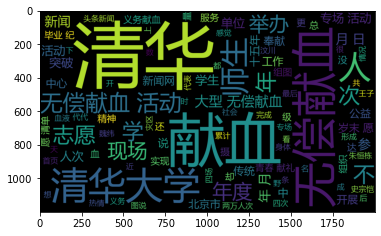

In [19]:
main("https://news.tsinghua.edu.cn/info/1002/16920.htm")